In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from stabda.utils import xr_load, get_results_path, get_distr_on_times, get_delay_times, get_session_ids, get_session_id_map

In [2]:
def create_summary_storage():
    sessions = get_session_ids()
    n_sessions = sessions.size
    
    delays = get_delay_times()
    n_delays = delays.size

    kernel_widths = np.array([5, 10, 15])
    n_kernel_widths = kernel_widths.size
    
    epochs = np.array(['distr', 'pre_test'])
    n_epochs = epochs.size
    

    res = xr.DataArray(
        np.zeros((n_sessions, n_delays, n_kernel_widths, n_epochs)),
        dims=["session", "delay", "kernel_width", "epoch"],
        coords={"session": sessions, "delay": delays, 
                "kernel_width": kernel_widths, "epoch": epochs},
    )

    return res


In [3]:
summary_res = create_summary_storage()

In [4]:
kws = [5, 10, 15]

for kw in kws:
    filename = f'distance_distr_{kw}.nc'
    results_path = get_results_path()
    filepath = os.path.join(results_path, filename)
    res = xr_load(filepath)
    
    delays = res.delay.data
    time = res.timepts.data
    distr_start_dict = get_distr_on_times()
    sessions = get_session_ids()
    session_map = get_session_id_map()
    
    for delay in delays:
        
        distr_dists = np.zeros((sessions.size, delays.size))
        pre_test_dists = np.zeros((sessions.size, delays.size))
        
        for i, session in enumerate(sessions):
            session_int = session_map[session]
            for j, delay in enumerate(delays):
                sample_on = 2000
                bs = res.loc[:,delay,:].data
                
                bsid_filt = (res.bsid == session_map[session])
                bsavg = res.loc[:,delay,:].where(bsid_filt, drop=True).data
                
                baseline = bsavg.mean(0)[sample_on-10]
                ys = (bsavg - baseline).mean(0)

                test_start = ((delay*1000)+500) * 1e-3
                distr_start = (distr_start_dict[delay])

                distr_filt = ((time > distr_start) & (time < distr_start + 0.25))
                pre_test_filt = ((time > test_start - 0.10) & (time < test_start))

                distr = ys[distr_filt].mean()
                pre_t = ys[pre_test_filt].mean()
                
                distr_dists[i,j] = distr
                pre_test_dists[i,j] = pre_t
        
        summary_res.loc[:,:,kw,'distr'] = distr_dists
        summary_res.loc[:,:,kw,'pre_test'] = pre_test_dists

In [5]:
from scipy.stats import wilcoxon

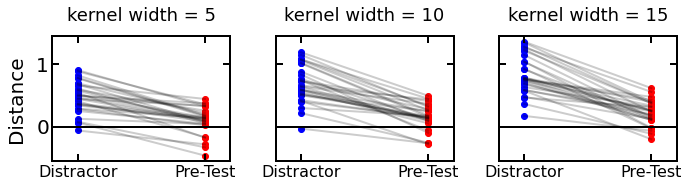

In [7]:
plt.style.use('../sci_style.py')
fig, ax = plt.subplots(1,3, figsize = (10,3), sharey=True)
pvals = []
for i, kw in enumerate(kws):
    d_data = summary_res.loc[:,:,kw,'distr'].data.flatten()
    pt_data = summary_res.loc[:,:,kw,'pre_test'].data.flatten()
    
    test = wilcoxon(d_data, pt_data)
    pval = test.pvalue
    pvals.append(pval)
    
    ax[i].scatter(np.repeat(0,d_data.size),d_data, color='b')
    ax[i].scatter(np.repeat(1,pt_data.size),pt_data, color='r')
    for q in range(d_data.size):
        ax[i].plot([d_data[q], pt_data[q]], color='k', alpha=0.2)
        
    ax[i].axhline(0, color='k')
        
    ax[i].set_title(f'kernel width = {kw}', fontsize=18)
    ax[i].set_xlim([-0.2,1.2])
    ax[i].set_xticks([0,1])
    ax[i].set_xticklabels(['Distractor', 'Pre-Test'], fontsize=16)
    if i == 0:
        ax[i].set_ylabel('Distance')
    
plt.tight_layout()
plt.savefig('figures/distance_distr_hyper.png', dpi=300)

In [8]:
from statsmodels.stats.multitest import fdrcorrection
pvals_c = fdrcorrection(pvals, alpha=0.05)

In [9]:
pvals_c

(array([ True,  True,  True]),
 array([1.73439763e-06, 1.73439763e-06, 1.73439763e-06]))